# VGG-16 Model 1b
## Preprocessing method: image_dataset_from_directory
## (224, 224) Grayscaled images

In [1]:
import pandas as pd
import numpy as np
import io
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
path_training = 'gender_images/Training/'
path_validation = 'gender_images/Validation/'

In [3]:
# import keras 
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# image_size = (90, 90)
# batch_size = 64

# target_size = (224, 224)
# input_shape=(224, 224, 3)
# min_lr = 0.0001
# steps_per_epoch=256
# validation_steps=256
# epochs=8


# train_datagen = ImageDataGenerator(rescale = 1./255,
#       rotation_range=25,
#       width_shift_range=0.2,
#       height_shift_range=0.2,
#       shear_range=0.2,
#       zoom_range=0.2,
#       horizontal_flip=True,
#       fill_mode='nearest')

# test_datagen = ImageDataGenerator( rescale = 1.0/255)

# train_generator = train_datagen.flow_from_directory(
#     path_training,
#     seed=10,
#     target_size=(224,224),
#     batch_size=batch_size,
#     classes=['female','male'],
#     shuffle=True,
# )

# validation_generator = test_datagen.flow_from_directory(
#     path_validation,
#     seed=10,
#     target_size=(224,224),
#     batch_size=batch_size,
#     classes=['female','male'],
#     shuffle=True
# )

In [4]:
image_size = (224, 224)
batch_size = 128
train_ds = tf.keras.preprocessing.image_dataset_from_directory(path_training,
                                                               color_mode = "grayscale",
                                                               seed=1993,
                                                               image_size = image_size)

val_ds =  tf.keras.preprocessing.image_dataset_from_directory(path_validation,
                                                              seed=1993,
                                                              color_mode = "grayscale",
                                                              subset='training',
                                                              validation_split=0.20,
                                                              image_size = image_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(path_validation,
                                                              seed=1993,
                                                              color_mode = "grayscale",
                                                              subset='validation',
                                                              validation_split=0.20,
                                                              image_size = image_size)

one_hot_encoded_train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=2)))
one_hot_encoded_val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=2)))
one_hot_encoded_test_ds = test_ds.map(lambda x, y: (x, tf.one_hot(y, depth=2)))

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

Found 47009 files belonging to 2 classes.
Found 11649 files belonging to 2 classes.
Using 9320 files for training.
Found 11649 files belonging to 2 classes.
Using 2329 files for validation.


In [5]:
plt.figure(figsize=(10, 10))
class_names = test_ds.class_names
for images, labels in test_ds.take(1):
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

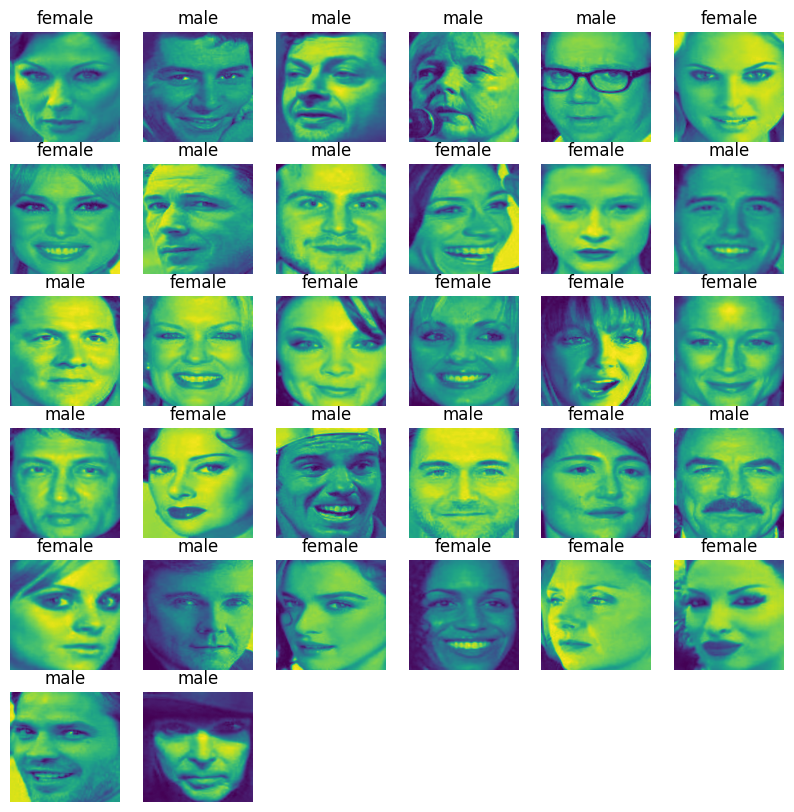

In [6]:
plt.show()

In [7]:
vgg_model = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg_model.trainable = False

# Model layers
input_tensor = tf.keras.layers.Input(shape=(224, 224, 1))
x = keras.layers.Conv2D(3,(3,3),padding='same')(input_tensor)
x = vgg_model(x)
out = keras.layers.Dense(2, activation='softmax')(x)

# Set early stopping after certain number of epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
epochs=1000     # Set epochs

# Generate model
model = keras.Model(inputs = input_tensor, outputs = out)
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       30        
                                                                 
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 dense (Dense)               (None, 2)                 2002      
                                                                 
Total params: 138,359,576
Trainable params: 2,032
Non-trainable params: 138,357,544
_________________________________________________________________


In [8]:
vgg16_fit = model.fit(one_hot_encoded_train_ds, 
                      epochs=epochs, 
                      validation_data=one_hot_encoded_val_ds,
                      callbacks=[callback])

Epoch 1/1000
1470/1470 [==============================] - 175s 112ms/step - loss: 0.6111 - accuracy: 0.7511 - val_loss: 0.5459 - val_accuracy: 0.7716
Epoch 2/1000
1470/1470 [==============================] - 164s 112ms/step - loss: 0.5311 - accuracy: 0.7633 - val_loss: 0.5043 - val_accuracy: 0.7755
Epoch 3/1000
1470/1470 [==============================] - 164s 112ms/step - loss: 0.5054 - accuracy: 0.7714 - val_loss: 0.4845 - val_accuracy: 0.7834
Epoch 4/1000
1470/1470 [==============================] - 164s 112ms/step - loss: 0.4903 - accuracy: 0.7805 - val_loss: 0.4707 - val_accuracy: 0.7932
Epoch 5/1000
1470/1470 [==============================] - 165s 112ms/step - loss: 0.4777 - accuracy: 0.7900 - val_loss: 0.4581 - val_accuracy: 0.8041
Epoch 6/1000
1470/1470 [==============================] - 164s 111ms/step - loss: 0.4662 - accuracy: 0.7988 - val_loss: 0.4459 - val_accuracy: 0.8134
Epoch 7/1000
1470/1470 [==============================] - 165s 112ms/step - loss: 0.4554 - accuracy:

1470/1470 [==============================] - 168s 114ms/step - loss: 0.3344 - accuracy: 0.8653 - val_loss: 0.3148 - val_accuracy: 0.8737
Epoch 56/1000
1470/1470 [==============================] - 167s 113ms/step - loss: 0.3332 - accuracy: 0.8659 - val_loss: 0.3145 - val_accuracy: 0.8753
Epoch 57/1000
1470/1470 [==============================] - 166s 113ms/step - loss: 0.3326 - accuracy: 0.8665 - val_loss: 0.3252 - val_accuracy: 0.8708
Epoch 58/1000
1470/1470 [==============================] - 164s 111ms/step - loss: 0.3351 - accuracy: 0.8647 - val_loss: 0.3145 - val_accuracy: 0.8768
Epoch 59/1000
1470/1470 [==============================] - 164s 112ms/step - loss: 0.3310 - accuracy: 0.8664 - val_loss: 0.3181 - val_accuracy: 0.8732
Epoch 60/1000
1470/1470 [==============================] - 164s 112ms/step - loss: 0.3298 - accuracy: 0.8687 - val_loss: 0.3139 - val_accuracy: 0.8773
Epoch 61/1000
1470/1470 [==============================] - 168s 114ms/step - loss: 0.3290 - accuracy: 0.8676

1470/1470 [==============================] - 168s 114ms/step - loss: 0.3054 - accuracy: 0.8790 - val_loss: 0.2927 - val_accuracy: 0.8850
Epoch 110/1000
1470/1470 [==============================] - 173s 118ms/step - loss: 0.3050 - accuracy: 0.8788 - val_loss: 0.2900 - val_accuracy: 0.8853
Epoch 111/1000
1470/1470 [==============================] - 169s 115ms/step - loss: 0.3038 - accuracy: 0.8800 - val_loss: 0.2902 - val_accuracy: 0.8856
Epoch 112/1000
1470/1470 [==============================] - 172s 117ms/step - loss: 0.3047 - accuracy: 0.8802 - val_loss: 0.2880 - val_accuracy: 0.8859
Epoch 113/1000
1470/1470 [==============================] - 171s 117ms/step - loss: 0.3036 - accuracy: 0.8797 - val_loss: 0.2879 - val_accuracy: 0.8880
Epoch 114/1000
1470/1470 [==============================] - 173s 118ms/step - loss: 0.3047 - accuracy: 0.8792 - val_loss: 0.2869 - val_accuracy: 0.8853
Epoch 115/1000
1470/1470 [==============================] - 172s 117ms/step - loss: 0.3040 - accuracy: 

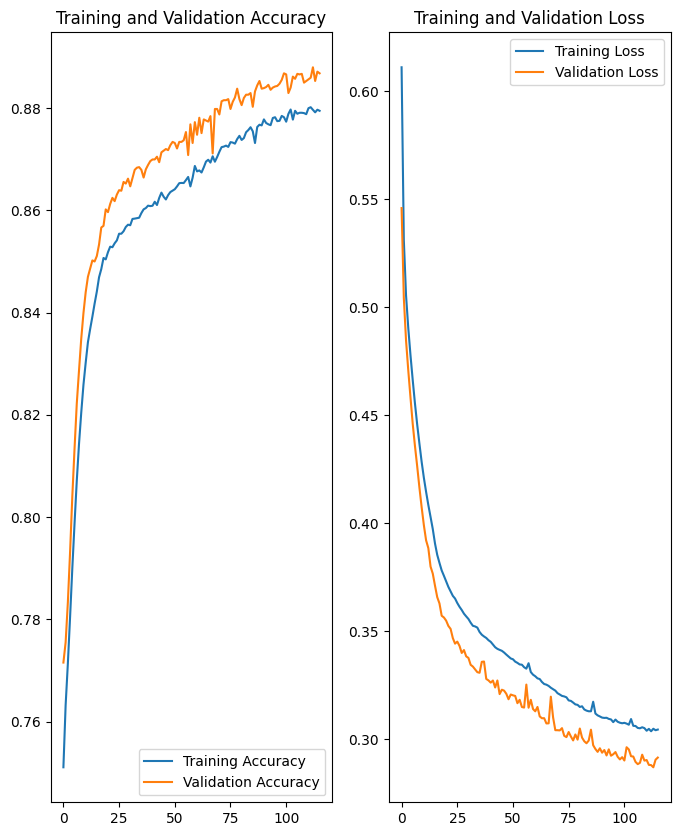

In [13]:
acc= vgg16_fit.history['accuracy']
val_acc = vgg16_fit.history['val_accuracy']

loss = vgg16_fit.history['loss']
val_loss = vgg16_fit.history['val_loss']

epochs_range = range(0, 116)

plt.figure(figsize=(8, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
# Test model on new image data (test set)
predictions = model.predict(one_hot_encoded_test_ds)

73/73 [==============================] - 5s 64ms/step


In [15]:
predicted_class = np.argmax(predictions, axis=-1)

In [16]:
predicted_class

array([1, 0, 0, ..., 0, 0, 1])